#1

In [488]:
# Generate Deflections of a cantilever beam analytically
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


# Parameters
L = 2.0             # Length of the beam [m]
EI = 2e6            # Flexural rigidity [Nm^2]
Q = 1000.0 # Uniform load [N/m]
P = 1000.0           # Point load [N]
a = L / 2            # Load applied at midspan
hinge_loc = L / 2.

dl = 0.01 * L

Noise = False

In [489]:

x_full = np.linspace(0, L, 200)
x_full_norm = x_full/ L

def w(x, L, Q):
 w = (Q * x**2 * (6*L**2 - 4*L*x + x**2)) / (24 * EI)
 return w

def w_point_load(x, L, P, a):
    w = np.zeros_like(x)
    mask1 = x <= a
    mask2 = x > a
    w[mask1] = (P * x[mask1]**2 * (3*a - x[mask1])) / (6 * EI)
    w[mask2] = (P * a**2 * (3*x[mask2] - a)) / (6 * EI)
    return w

def w_udl_hinge(x, hinge_loc, L, Q):
  x_left, x_right = x[x <= hinge_loc], x[hinge_loc < x]
  return np.concatenate([w(x_left, hinge_loc, Q), w(x_right - x_right[0], L - hinge_loc, Q)[::-1]])

def w_udl_hinge(x, hinge_loc, L, q):
    x = np.asarray(x)
    w_out = np.zeros_like(x, dtype=float)

    left  = x <= hinge_loc          # choose one side to hold the equality consistently
    right = ~left

    # Left half: cantilever fixed at x=0, free at x=hinge_loc
    s_left = x[left]                      # distance from fixed end
    w_out[left] = w(s_left, hinge_loc, q)

    # Right half: mirror—cantilever fixed at x=L, free at x=hinge_loc
    s_right = L - x[right]                # distance from right fixed end
    w_out[right] = w(s_right, L - hinge_loc, q)

    return w_out

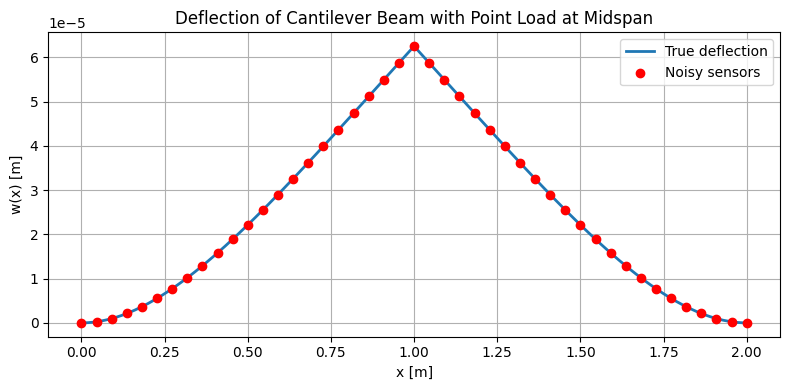

In [490]:
x_full = np.linspace(0, L, 200)

w_true = w(x_full, L, Q)
w_true = w_udl_hinge(x_full, hinge_loc, L, Q)
#w_true = w(x_full, L, Q)

x_sensors = np.linspace(0, L, 45)
w_sensors_clean = w_udl_hinge(x_sensors, hinge_loc, L, Q)
#w_sensors_clean = w(x_sensors, L, Q)
w_sensors = w_sensors_clean

if Noise:
  np.random.seed(42)
  noise_std = 0.05 * np.max(w_sensors_clean)
  noise = np.random.normal(0, noise_std, size=w_sensors_clean.shape)
  w_sensors += noise

# Plot
plt.figure(figsize=(8, 4))
plt.plot(x_full, w_true, label="True deflection", linewidth=2)
plt.scatter(x_sensors, w_sensors, color='red', label="Noisy sensors", zorder=3)
plt.xlabel("x [m]")
plt.ylabel("w(x) [m]")
plt.title("Deflection of Cantilever Beam with Point Load at Midspan")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#2

In [491]:
x_sensors_norm = (x_sensors / L).reshape(-1, 1)
w_max = w_sensors_clean.max()  # still use clean max for scaling
w_sensors_norm = (w_sensors / w_max).reshape(-1, 1)

x_tf = tf.convert_to_tensor(x_full_norm, dtype=tf.float32)
x_sensors_tf = tf.convert_to_tensor(x_sensors_norm, dtype=tf.float32)
w_sensors_tf = tf.convert_to_tensor(w_sensors_norm.reshape(-1, 1), dtype=tf.float32)

q_hat_norm = tf.Variable(0.0, dtype=tf.float32)

In [492]:
model_w = keras.models.Sequential([
        keras.layers.Input(shape=(1,)),
        keras.layers.Dense(64, activation='swish', dtype = tf.float32),
        keras.layers.Dense(64, activation='swish', dtype = tf.float32),
        keras.layers.Dense(64, activation='swish', dtype = tf.float32),
        keras.layers.Dense(1,)
    ])

model_b = keras.models.Sequential([
        keras.layers.Input(shape=(1,)),
        keras.layers.Dense(64, activation='relu', dtype = tf.float32),
        keras.layers.Dense(64, activation='relu', dtype = tf.float32),
        keras.layers.Dense(64, activation='relu', dtype = tf.float32),
        keras.layers.Dense(1, activation = 'sigmoid')
    ])

optimizer_w = keras.optimizers.Adam(learning_rate = 1e-4)
optimizer_b = keras.optimizers.Adam(learning_rate = 1e-4)
optimizer_q = keras.optimizers.Adam(learning_rate = 1e-4)

def compute_derivatives_bc(x_input):
    with tf.GradientTape() as tape4:
        tape4.watch(x_input)
        with tf.GradientTape() as tape3:
            tape3.watch(x_input)
            with tf.GradientTape() as tape2:
                tape2.watch(x_input)
                with tf.GradientTape() as tape1:
                    tape1.watch(x_input)
                    w_hat = model_w(x_input)
                dw = tape1.gradient(w_hat, x_input)
            d2w = tape2.gradient(dw, x_input)
        d3w = tape3.gradient(d2w, x_input)
    d4w = tape4.gradient(d3w, x_input)
    return w_hat, dw, d2w, d3w, d4w

def discrete_derivatives(x):

    dl_norm = tf.convert_to_tensor(dl / L, dtype = tf.float32)

    y_m2 = model_w(x - 2.0*dl_norm)
    y_m1 = model_w(x - 1.0*dl_norm)
    y_0  = model_w(x)
    y_p1 = model_w(x + 1.0*dl_norm)
    y_p2 = model_w(x + 2.0*dl_norm)

    d1 = (y_p1 - y_m1) / (2.0*dl_norm)

    d4 = (y_m2 - 4.0*y_m1 + 6.0*y_0 - 4.0*y_p1 + y_p2) / (dl_norm**4)

    return d1, d4

DISCRETE = False
if DISCRETE:
    compute_derivatives = discrete_derivatives
else:
    compute_derivatives = compute_derivatives_bc


In [493]:
@tf.function
def train_step_data():
    with tf.GradientTape(persistent=True) as tape:

        w_pred = model_w(x_sensors_tf)
        data_loss = tf.reduce_mean(tf.square(w_pred - w_sensors_tf))

        w0, dw0, *_ = compute_derivatives_bc(tf.convert_to_tensor([0.0, 1.0], dtype=tf.float32))
        bc_loss = tf.reduce_mean(tf.square(w0)) + tf.reduce_mean(tf.square(dw0 / L))

        w_data, w_bc = 1.0, 0.1
        differentiable_loss = w_data * data_loss + w_bc * bc_loss

    variables = model_w.trainable_variables
    grads = tape.gradient(differentiable_loss, variables)
    optimizer_w.apply_gradients(zip(grads, variables))

    *_, d4w_norm = compute_derivatives(x_sensors_tf)
    q_hat_tf = tf.ones_like(d4w_norm) * q_hat_norm
    physics_residual = d4w_norm * (EI * w_max / (L**4 * Q)) - q_hat_tf
    physics_loss = tf.reduce_mean(tf.square(physics_residual))
    filter_penalty = np.nan

    total_loss = sum([data_loss, bc_loss, physics_loss])
    return total_loss, data_loss, bc_loss, physics_loss, filter_penalty, d4w_norm

In [494]:
@tf.function
def train_step_filter(d4w_norm):
    with tf.GradientTape(persistent=True) as tape:

        b_pred = model_b(x_sensors_tf)
        q_hat_tf = tf.ones_like(d4w_norm) * q_hat_norm
        physics_residual = d4w_norm * (EI * w_max / (L**4 * Q)) - q_hat_tf
        filtered_residual = b_pred * physics_residual

        physics_loss = tf.reduce_mean(tf.square(filtered_residual))
        filter_penalty = tf.reduce_mean(tf.square(1 - b_pred))
        filter_penalty = tf.exp( 10 * filter_penalty)

        tv_b = b_pred[1:] - b_pred[:-1]
        tv_b = tf.reduce_mean(tf.square(tv_b))

        w_physics, w_filter = 0.1, 0.1
        differentiable_loss = w_physics * physics_loss + w_filter * filter_penalty + 0.1 * tv_b

    grads_b = tape.gradient(differentiable_loss, model_b.trainable_variables)
    optimizer_b.apply_gradients(zip(grads_b, model_b.trainable_variables))

    return physics_loss, filter_penalty

In [495]:
@tf.function
def train_step_intermediate(): # still not updating q
    with tf.GradientTape(persistent=True) as tape:

        w_pred = model_w(x_sensors_tf)
        b_pred = model_b(x_sensors_tf)

        data_loss = tf.reduce_mean(tf.square(w_pred - w_sensors_tf))

        w0, dw0, *_ = compute_derivatives_bc(tf.convert_to_tensor([0.0, 1.0], dtype=tf.float32))
        bc_loss = tf.reduce_mean(tf.square(w0)) + tf.reduce_mean(tf.square(dw0 / L))

        *_, d4w_norm = compute_derivatives(x_sensors_tf)
        q_hat_tf = tf.ones_like(d4w_norm) * q_hat_norm
        physics_residual = d4w_norm * (EI * w_max / (L**4 * Q)) - q_hat_tf
        filtered_residual = b_pred * physics_residual

        physics_loss = tf.reduce_mean(tf.square(filtered_residual))
        spikes_penalty = tf.reduce_mean(tf.square(filtered_residual[1:] - filtered_residual[:-1]))
        
        filter_penalty = tf.reduce_mean(tf.square(1 - b_pred))
        filter_penalty = tf.exp(5 * filter_penalty)

        w_data, w_bc, w_phys, w_spikes, w_fil = 5.0, 0.1, 0.002, 0.1, 0.001
        differentiable_loss = w_data * data_loss + w_bc * bc_loss + w_phys * physics_loss + w_spikes * spikes_penalty + w_fil * filter_penalty


    grads_w = tape.gradient(differentiable_loss, model_w.trainable_variables)
    grads_b = tape.gradient(differentiable_loss, model_b.trainable_variables)

    optimizer_w.apply_gradients(zip(grads_w, model_w.trainable_variables))
    optimizer_b.apply_gradients(zip(grads_b, model_b.trainable_variables))

    total_loss = sum([data_loss, bc_loss, physics_loss, filter_penalty])
    return total_loss, data_loss, bc_loss, physics_loss, filter_penalty

In [496]:
@tf.function
def train_step_final():
    with tf.GradientTape(persistent=True) as tape:

        w_pred = model_w(x_sensors_tf)
        b_pred = model_b(x_sensors_tf)

        data_loss = tf.reduce_mean(tf.square(w_pred - w_sensors_tf))

        w0, dw0, *_ = compute_derivatives_bc(tf.convert_to_tensor([0.0, 1.0], dtype=tf.float32))
        bc_loss = tf.reduce_mean(tf.square(w0)) + tf.reduce_mean(tf.square(dw0 / L))

        *_, d4w_norm = compute_derivatives(x_sensors_tf)
        q_hat_tf = tf.ones_like(d4w_norm) * q_hat_norm
        physics_residual = d4w_norm * (EI * w_max / (L**4 * Q)) - q_hat_tf
        filtered_residual = b_pred * physics_residual

        physics_loss = tf.reduce_mean(tf.square(filtered_residual))
        spikes_penalty = tf.reduce_mean(tf.square(filtered_residual[1:] - filtered_residual[:-1]))
        
        filter_penalty = tf.reduce_mean(tf.square(1 - b_pred))
        filter_penalty = tf.exp(5 * filter_penalty)

        w_data, w_bc, w_phys, w_spikes, w_fil = 5.0, 0.1, 0.002, 0.1, 0.001
        differentiable_loss = w_data * data_loss + w_bc * bc_loss + w_phys * physics_loss + w_spikes * spikes_penalty + w_fil * filter_penalty


    grads_w = tape.gradient(differentiable_loss, model_w.trainable_variables)
    grads_b = tape.gradient(differentiable_loss, model_b.trainable_variables)
    grads_q = tape.gradient(differentiable_loss, [q_hat_norm])

    optimizer_w.apply_gradients(zip(grads_w, model_w.trainable_variables))
    optimizer_b.apply_gradients(zip(grads_b, model_b.trainable_variables))
    optimizer_q.apply_gradients(zip(grads_q, [q_hat_norm]))

    total_loss = sum([data_loss, bc_loss, physics_loss, filter_penalty])
    return total_loss, data_loss, bc_loss, physics_loss, filter_penalty

In [497]:
Data_only = False
N_DATA = 20000
N_FILTER = 10000
N_INTERM = 5000
N_INTEGRATE = 30000


history = {"loss": [], "data": [], "phys": [], "bc": [], "filter": [], "q_hat_norm": []}

In [498]:

for epoch in range(N_DATA + N_FILTER + N_INTERM + N_INTEGRATE):

    if epoch < N_DATA:
      loss, data_l, bc_l, phys_l, filter_l, d4w_norm = train_step_data()
    elif epoch < N_DATA + N_FILTER:
      phys_l, filter_l = train_step_filter(d4w_norm)
      data_l, bc_l = tf.cast(history["data"][-1], tf.float32), tf.cast(history["bc"][-1], tf.float32)
      loss = phys_l + filter_l + data_l + bc_l
    elif epoch < N_DATA + N_FILTER + N_INTERM:
      loss, data_l, bc_l, phys_l, filter_l = train_step_intermediate()
    else:
      loss, data_l, bc_l, phys_l, filter_l = train_step_final()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch:5d} | Total: {loss.numpy().item():.6f} | "f"Data: {data_l.numpy().item():.6f} | Phys: {phys_l.numpy().item():.6f} | BC: {bc_l.numpy().item():.6f}| Filter: {filter_l.numpy().item():.6f}| Predicted q: {q_hat_norm.numpy()}")
    history["loss"].append(loss.numpy().item())
    history["data"].append(data_l.numpy().item())
    history["phys"].append(phys_l.numpy().item())
    history["bc"].append(bc_l.numpy().item())
    history["filter"].append(filter_l.numpy().item())
    history["q_hat_norm"].append(q_hat_norm.numpy().item())

Epoch     0 | Total: 0.269614 | Data: 0.268543 | Phys: 0.000000 | BC: 0.001071| Filter: nan| Predicted q: 0.0
Epoch  1000 | Total: 0.213135 | Data: 0.094048 | Phys: 0.000000 | BC: 0.119087| Filter: nan| Predicted q: 0.0
Epoch  2000 | Total: 0.299737 | Data: 0.064387 | Phys: 0.000083 | BC: 0.235267| Filter: nan| Predicted q: 0.0
Epoch  3000 | Total: 0.305013 | Data: 0.062391 | Phys: 0.000920 | BC: 0.241702| Filter: nan| Predicted q: 0.0
Epoch  4000 | Total: 22.899269 | Data: 0.002734 | Phys: 22.895365 | BC: 0.001171| Filter: nan| Predicted q: 0.0
Epoch  5000 | Total: 33.794785 | Data: 0.001398 | Phys: 33.793301 | BC: 0.000082| Filter: nan| Predicted q: 0.0
Epoch  6000 | Total: 62.091084 | Data: 0.000896 | Phys: 62.090023 | BC: 0.000163| Filter: nan| Predicted q: 0.0
Epoch  7000 | Total: 78.014450 | Data: 0.000728 | Phys: 78.013550 | BC: 0.000174| Filter: nan| Predicted q: 0.0
Epoch  8000 | Total: 156.223312 | Data: 0.000498 | Phys: 156.222717 | BC: 0.000090| Filter: nan| Predicted q: 0.

In [499]:
# Final predictions
#x_plot = np.linspace(0,L,200)
#x_tf = tf.convert_to_tensor(x_plot)
w_hat, dw, d2w, d3w, d4w = compute_derivatives_bc(x_tf)
#*_, d4w = discrete_derivatives(x_tf)

b_pred = model_b.predict(x_tf)
#b_pred = tf.where(b_pred >= 0.4, 1.0, 0.0)

print(b_pred.shape)
#print(b_pred * (d4w * (EI * w_max / (L**4 * Q))))
w_pred = w_hat.numpy() * w_max
#w_pred = scaler_w.inverse_transform(w_hat.numpy()).flatten()
#sigma_w = scaler_w.scale_[0]
#a_dim = a.numpy() * EI * w_max/ L**6
#b_dim = b.numpy() * EI * w_max/ L**5
c_dim = q_hat_norm.numpy()

# Step 2: Reconstruct q(x) in physical units
q_pred = c_dim.flatten()
q_pred = q_pred * Q

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
(200, 1)


R² score (PINN Model): 0.99923


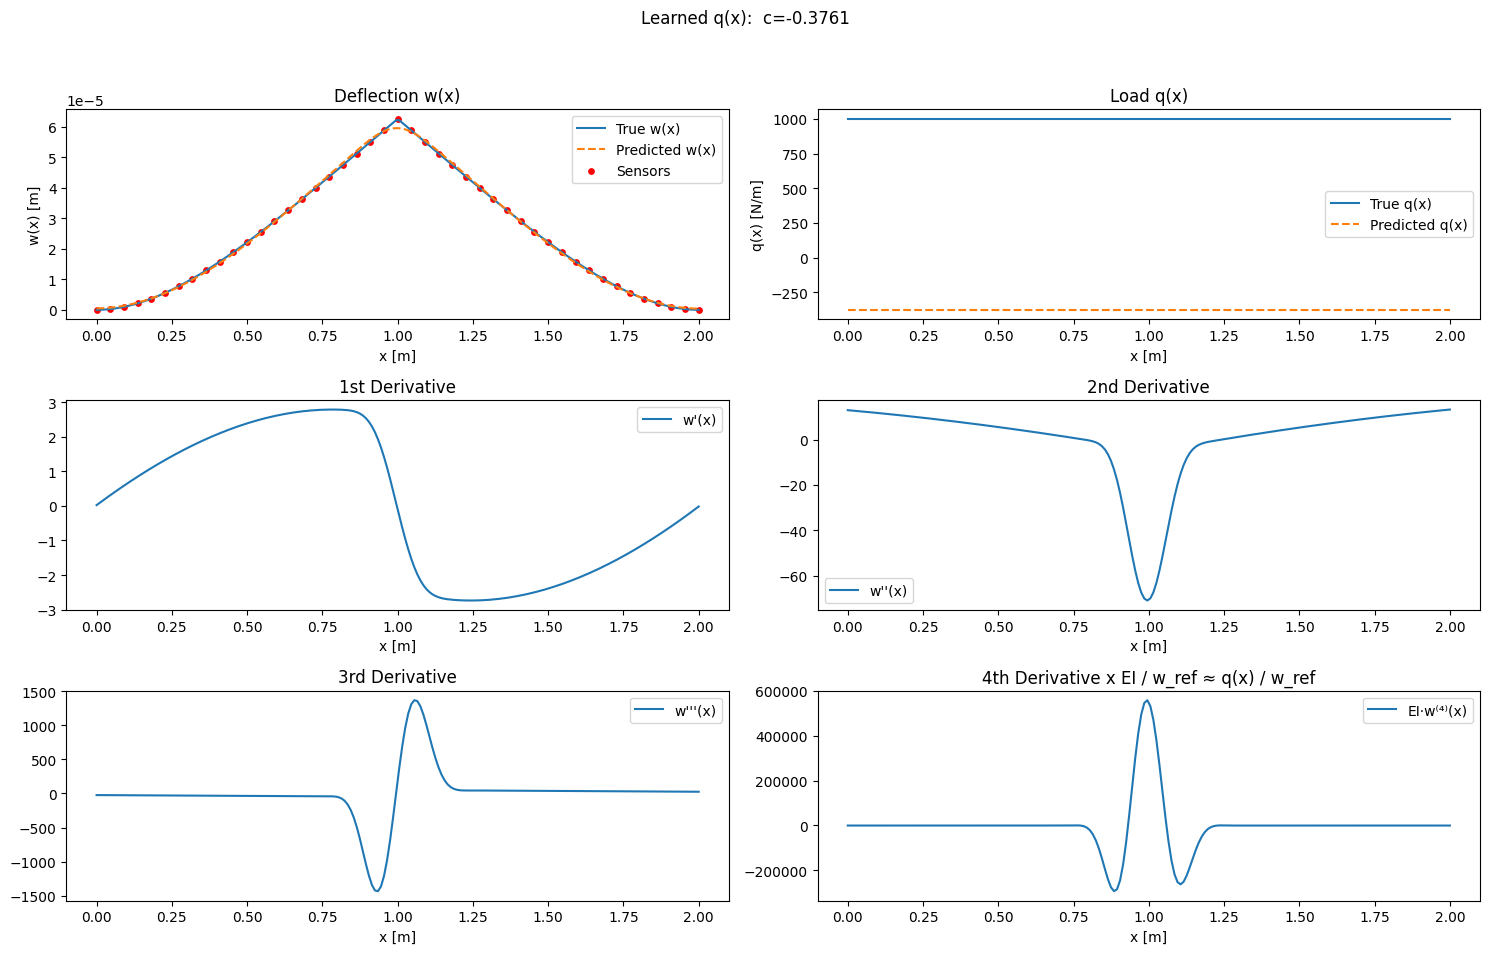

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.3761031925678253>

In [500]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(3, 2)

# Define plotting x and evaluate true values
x_plot = x_full  # Dimensional x values
#w_true = w_point_load(x_plot)  # True analytical deflection
q_true = Q * np.ones_like(x_plot)  # Constant uniform load

plt.subplot(gs[0, 0])
plt.plot(x_plot, w_true, label="True w(x)")
plt.plot(x_plot, w_pred, '--', label="Predicted w(x)")
plt.scatter(x_sensors, w_sensors, color='red', label="Sensors", s=15)
plt.title("Deflection w(x)")
plt.xlabel("x [m]")
plt.ylabel("w(x) [m]")
plt.legend()

plt.subplot(gs[0, 1])
plt.plot(x_plot, q_true, label="True q(x)")
plt.plot(x_plot, np.full_like(x_plot, q_pred), '--', label="Predicted q(x)")
plt.title("Load q(x)")
plt.xlabel("x [m]")
plt.ylabel("q(x) [N/m]")
plt.legend()

plt.subplot(gs[1, 0])
plt.plot(x_plot, dw.numpy(), label="w'(x)")
plt.title("1st Derivative")
plt.xlabel("x [m]")
plt.legend()

plt.subplot(gs[1, 1])
plt.plot(x_plot, d2w.numpy(), label="w''(x)")
plt.title("2nd Derivative")
plt.xlabel("x [m]")
plt.legend()

plt.subplot(gs[2, 0])
plt.plot(x_plot, d3w.numpy(), label="w'''(x)")
plt.title("3rd Derivative")
plt.xlabel("x [m]")
plt.legend()

# Ensure w_ref is defined for correct scaling
w_ref = L**4 / EI

plt.subplot(gs[2, 1])
plt.plot(x_plot, d4w * w_max / w_ref, label="EI·w⁽⁴⁾(x)")
#plt.plot(x_plot, q_pred , '--', label="Predicted q(x) / w_ref")
plt.title("4th Derivative x EI / w_ref ≈ q(x) / w_ref")
plt.xlabel("x [m]")
plt.legend()
plt.suptitle(f"Learned q(x):  c={c_dim:.4f}")

from sklearn.metrics import r2_score
r2_data = r2_score(w_true, w_pred)
print(f"R² score (PINN Model): {r2_data:.5f}")
#plt.suptitle(f"Learned q(x): a={a_dim:.4f}, b={b_dim:.4f}, c={c_dim:.4f}")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
# Compute R²


q_hat_norm

In [501]:
with tf.GradientTape() as tape1:
    w_hat, dw, d2w, d3w, d4w = compute_derivatives_bc(x_tf)
    b_pred = tf.squeeze(model_b.predict(x_tf))
    q_hat_tf = tf.ones_like(d4w) * q_hat_norm
    physics_residual = d4w * (EI * w_max / (L**4 * Q)) - q_hat_norm
    filtered_residual = b_pred * physics_residual
    physics_loss = tf.reduce_mean(b_pred * tf.square(physics_residual))
    #physics_loss = tf.reduce_mean(tf.square(filtered_residual))
gradq = tape1.gradient(physics_loss, [q_hat_norm])
optimizer_q.apply_gradients(zip(gradq, [q_hat_norm]))
print(gradq, q_hat_norm)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[<tf.Tensor: shape=(), dtype=float32, numpy=0.025201380252838135>] <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.3763510286808014>


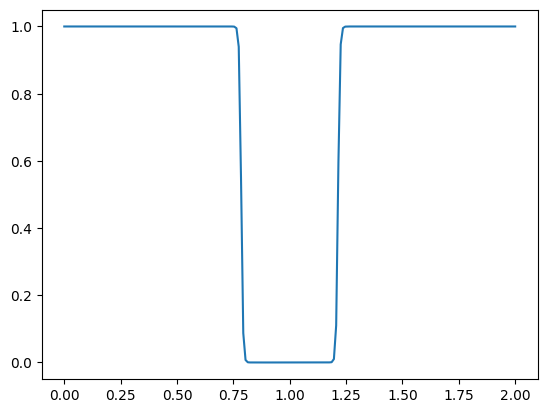

TensorShape([200])

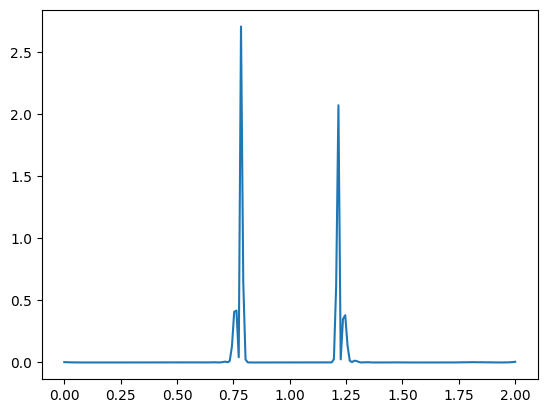

In [502]:

plt.plot(x_full, b_pred)
plt.show()
plt.plot(x_full,tf.square((b_pred) *  (d4w * (EI * w_max / (L**4 * Q)) - q_hat_norm)))
b_pred.shape

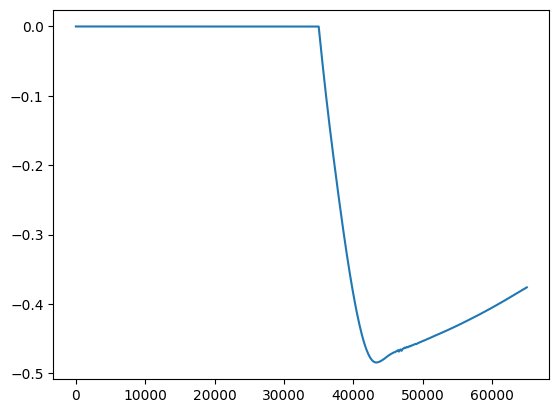

In [503]:
plt.plot(history['q_hat_norm'])

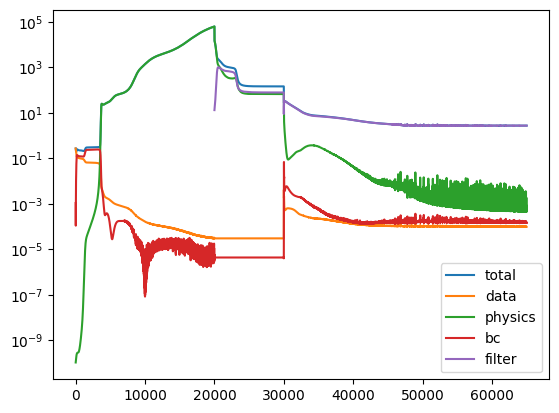

In [504]:
plt.plot(history['loss'], label = 'total')
plt.plot(history['data'], label = 'data')
plt.plot(history['phys'], label = 'physics')
plt.plot(history['bc'], label = 'bc')
plt.plot(history['filter'], label = 'filter')
plt.legend()
plt.yscale('log')